In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
import pandas as pd
from rdkit import Chem
from tqdm import tqdm
from serenityff.charge.tree.dash_tree import DASHTree
from serenityff.charge.tree.atom_features import AtomFeatures
from rdkit import Chem
import torch
import sys
#add path to custom_featurization_stuff
sys.path.append("/localhome/cschiebroek/MDFPs/mdfptools/carl/Experiments_result_analysis/")
from custom_featurization_stuff import get_graph_from_mol
allowable_set= ["C","N","O","F","P","S","Cl","Br","I","H"]
from sklearn.model_selection import train_test_split
#also add r2
from sklearn.metrics import r2_score
#also add pearson
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [3]:
#start with loading the data
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools

# Function to read SDF file and extract properties
def read_sdf(file_path):
    suppl = Chem.SDMolSupplier(file_path)
    data = []
    for mol in suppl:
        if mol is not None:
            smiles = Chem.MolToSmiles(mol)
            logP = mol.GetProp('LogP') if mol.HasProp('LogP') else None
            logVP = mol.GetProp('LogVP') if mol.HasProp('LogVP') else None
            data.append({'SMILES': smiles, 'logP': logP, 'logVP': logVP})
    return data

# File paths for your SDF files
vp_path = 'OPERA_Data/VP_QR.sdf'
logp_path = 'OPERA_Data/LogP_QR.sdf'

# Read SDF files and extract data
data_vp = read_sdf(vp_path)
data_logp = read_sdf(logp_path)

# Create Pandas dataframes
df_vp = pd.DataFrame(data_vp)
df_logp = pd.DataFrame(data_logp)

#get the smiles for both
smiles_vp = df_vp['SMILES'].tolist()
smiles_logp = df_logp['SMILES'].tolist()
#get combined smiles
smiles_all = smiles_vp + smiles_logp
smiles_all = [s for s in smiles_all if s is not None]
smiles_all = list(set(smiles_all))
#foreach smile in overlap, get the logP from df2 and the logVP from df1
logP = []
logVP = []
for smile in smiles_all:
    #append val or 0.0 if not found
    logP.append(df_logp[df_logp['SMILES'] == smile]['logP'].values[0] if smile in smiles_logp else 0.0)
    logVP.append(df_vp[df_vp['SMILES'] == smile]['logVP'].values[0] if smile in smiles_vp else 0.0)
    
#make a new dataframe
df = pd.DataFrame({'SMILES': smiles_all, 'logP': logP, 'logVP': logVP})
df



[20:30:43] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 12 22 23 24 25 26 27
[20:30:43] ERROR: Could not sanitize molecule ending on line 38202
[20:30:43] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 12 22 23 24 25 26 27


,SMILES,logP,logVP
0,N#CSCSc1nc2ccccc2s1,3.3,0.0
1,Oc1ccccc1CNc1ncnc2nc[nH]c12,2.05,0.0
2,CCCCCCCOc1ccc(NC(=O)OCCN2CCCCC2)cc1,5.87,0.0
3,C=CCCCN,0.81,0.0
4,COC1CC(OC2C(C)C(=O)OC(C)C(C)C(O)C(C)C(=O)C3(CO...,1.69,0.0
...,...,...,...
15075,O=[N+]([O-])c1ccc2c(O)cccc2c1,3.5,0.0
15076,CN(C)CCN(C)C,0.3,0.0
15077,C=CC(C)CCC,0.0,1.9159999393918141
15078,Clc1cc2c(cc1Cl)Oc1cc(Br)c(Br)cc1O2,0.0,-8.332500351289141


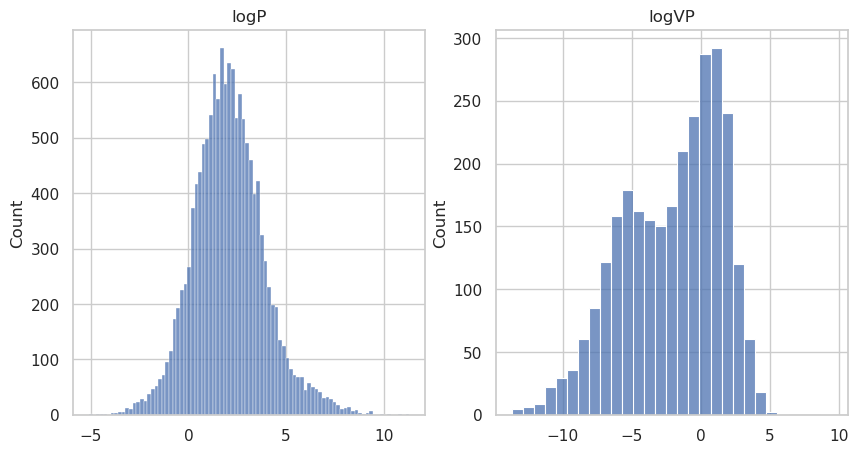

In [8]:
#do histograms of the logps and vps
df['logP'] = df['logP'].astype(float)
df['logVP'] = df['logVP'].astype(float)
logp_vals = df['logP'].tolist()
vp_vals = df['logVP'].tolist()
logp_vals = [x for x in logp_vals if x != 0.0]
vp_vals = [x for x in vp_vals if x != 0.0]
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(logp_vals, ax=ax[0])
ax[0].set_title('logP')
sns.histplot(vp_vals, ax=ax[1])
ax[1].set_title('logVP')
plt.show()


In [ ]:
# tree = DASHTree(tree_folder_path='/localhome/cschiebroek/other/serenityff-charge/tree')

Loading DASH tree data


In [ ]:
# all_mols = [Chem.MolFromSmiles(smi) for smi in df['SMILES']]
# mols = [m for m in all_mols if m.GetNumAtoms() > 1]
# error_mol = [m for m in all_mols if m.GetNumAtoms() <= 1]
# mols_with_charges = []
# error_mols_charges = []
# for m in tqdm(mols):
#     try:
#         mol = Chem.AddHs(m, addCoords=True)
#         charges = tree.get_molecules_partial_charges(mol,chg_std_key='std',chg_key='result')["charges"]
#     except:
#         error_mols_charges.append(m)
#         continue
#     for i,atom in enumerate(mol.GetAtoms()):
#         atom.SetDoubleProp('charge',charges[i])
#     mols_with_charges.append(mol)


100%|██████████| 15079/15079 [05:28<00:00, 45.88it/s]


In [9]:
all_mols = [Chem.MolFromSmiles(smi) for smi in df['SMILES']]
mols = [m for m in all_mols if m.GetNumAtoms() > 1]
error_mol = [m for m in all_mols if m.GetNumAtoms() <= 1]
indices_to_drop_size = [all_mols.index(m) for m in error_mol]
# indices_to_drop_charges = [all_mols.index(m) for m in error_mols_charges]
# indices_to_drop_total = list(set(indices_to_drop_size + indices_to_drop_charges))
# print(len(indices_to_drop_total), len(indices_to_drop_size), len(indices_to_drop_charges))

In [10]:
# if indices_to_drop_total:
#     print('Caution! Mols dropped')
#     df = df.drop(indices_to_drop_total)
if indices_to_drop_size:
    print('Caution! Mols dropped')
    df = df.drop(indices_to_drop_size)

Caution! Mols dropped


In [11]:
#set values of second two columns as floats
df['logP'] = df['logP'].astype(float)
df['logVP'] = df['logVP'].astype(float)

In [12]:
ys = df.iloc[:, -2:].values
y = torch.tensor(ys, dtype=torch.float32)
y = y.unsqueeze(1)

In [13]:
y[0]

tensor([[3.3000, 0.0000]])

In [15]:
assert len(mols) == len(y)
data = [get_graph_from_mol(mol,i, allowable_set,no_y=True) for i,mol in enumerate(mols)]
for i in range(len(data)):
    data[i].y = y[i]

In [16]:
#basics
import os
from math import sqrt
import pandas
import numpy as np
import random


#torch stuff
import torch
from torch.nn import functional as F
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_
from torch_geometric.nn.models import AttentiveFP
from torch_geometric.loader import DataLoader



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#set random seeds
torch.manual_seed(0)
torch.cuda.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(False)

def train_multi(train_loader, model, optimizer, device, outputs):
    total_loss = total_examples = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        weighted_loss = num_labels = 0
        for i in range(outputs):
            y_tmp = data.y[:, i]
            out_tmp = out[:, i]
            # Find indices where labels are available
            present_label_indices = torch.nonzero(y_tmp != 0.0).view(-1)
            num_labels += len(present_label_indices)

            if len(present_label_indices) > 0:
                # Extract only the available label indices
                out_tmp_present = torch.index_select(out_tmp, 0, present_label_indices)
                y_tmp_present = torch.index_select(y_tmp, 0, present_label_indices)

                # Calculate MSE loss only for available labels
                loss_tmp_present = F.mse_loss(out_tmp_present, y_tmp_present)
                if not torch.isnan(loss_tmp_present):
                    weighted_loss += loss_tmp_present * len(present_label_indices)

        weighted_loss = weighted_loss / num_labels
        weighted_loss.backward()

        total_loss += float(weighted_loss) * data.num_graphs
        total_examples += data.num_graphs

        # clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        del data

    return sqrt(total_loss / total_examples)


def validate_multi(val_loader, model, outputs):
    total_loss = total_examples = 0
    for data in val_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        weighted_loss = num_labels = 0
        for i in range(outputs):

            y_tmp = data.y[:, i]
            out_tmp = out[:, i]
            # Find indices where labels are available
            present_label_indices = torch.nonzero(y_tmp != 0.0).view(-1)
            num_labels += len(present_label_indices)

            if len(present_label_indices) > 0:
                # Extract only the available label indices
                out_tmp_present = torch.index_select(out_tmp, 0, present_label_indices)
                y_tmp_present = torch.index_select(y_tmp, 0, present_label_indices)

                # Calculate MSE loss only for available labels
                loss_tmp_present = F.mse_loss(out_tmp_present, y_tmp_present)
                if not torch.isnan(loss_tmp_present):
                    weighted_loss += loss_tmp_present * len(present_label_indices)

        weighted_loss = weighted_loss / num_labels

        total_loss += float(weighted_loss) * data.num_graphs
        total_examples += data.num_graphs
        del data

    return sqrt(total_loss / total_examples)

def train_and_validate_multi(model, train_loader, val_loader, optimizer, num_epochs, outputs, verbose=True):
    train_losses = []
    val_losses = []
    scheduler = ReduceLROnPlateau(optimizer, patience=2, factor=0.9,verbose=False)

    min_val_los = 1000
    for epoch in range(num_epochs):
        model.train()
        train_loss = train_multi(train_loader, model, optimizer, device, outputs)
        train_losses.append(train_loss)

        model.eval()
        val_loss = validate_multi(val_loader, model, outputs)
        val_losses.append(val_loss)
        scheduler.step(val_loss)

        if val_loss < min_val_los:
            min_val_los = val_loss
            counter = 0
            torch.save(model.state_dict(), 'test_model.pt')

        else:
            counter += 1
        if counter > 10:
            if verbose:
                print('early stopping')
            break
        if verbose:
            print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

In [17]:

torch.cuda.empty_cache()
train_data, test_data = train_test_split(data, test_size=0.2, random_state=0)
#split train in train and val
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=0)
# #datloaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)


/localhome/cschiebroek/.conda/envs/mtl_dc/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1100x23 and 24x200)

In [18]:
model= AttentiveFP(in_channels=23, hidden_channels=200, out_channels=2,
                            edge_dim=11, num_layers=4, num_timesteps=2,
                            dropout=0.0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=10**-3,
                        weight_decay=10**-4)
train_and_validate_multi(model, train_loader, val_loader, optimizer, num_epochs=100, outputs=2, verbose=True)

/localhome/cschiebroek/.conda/envs/mtl_dc/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100: Train Loss: 1.6542, Val Loss: 1.2772
Epoch 2/100: Train Loss: 1.1509, Val Loss: 1.0971
Epoch 3/100: Train Loss: 1.0236, Val Loss: 1.0069
Epoch 4/100: Train Loss: 0.9495, Val Loss: 0.8975
Epoch 5/100: Train Loss: 0.8724, Val Loss: 0.8218
Epoch 6/100: Train Loss: 0.8327, Val Loss: 0.8900
Epoch 7/100: Train Loss: 0.7904, Val Loss: 0.8062
Epoch 8/100: Train Loss: 0.7534, Val Loss: 0.8117
Epoch 9/100: Train Loss: 0.7358, Val Loss: 0.7468
Epoch 10/100: Train Loss: 0.7014, Val Loss: 0.7285
Epoch 11/100: Train Loss: 0.6823, Val Loss: 0.7117
Epoch 12/100: Train Loss: 0.6725, Val Loss: 0.7395
Epoch 13/100: Train Loss: 0.6592, Val Loss: 0.7142
Epoch 14/100: Train Loss: 0.6476, Val Loss: 0.6614
Epoch 15/100: Train Loss: 0.6189, Val Loss: 0.6613
Epoch 16/100: Train Loss: 0.6127, Val Loss: 0.6558
Epoch 17/100: Train Loss: 0.5887, Val Loss: 0.6850
Epoch 18/100: Train Loss: 0.5893, Val Loss: 0.6531
Epoch 19/100: Train Loss: 0.5929, Val Loss: 0.6821
Epoch 20/100: Train Loss: 0.5781, Val Lo

In [20]:
from scipy.stats import spearmanr,kendalltau
def get_preds_per_task(val_loader, model, outputs):
    preds = tuple([[] for i in range(outputs)])
    ys = tuple([[] for i in range(outputs)])
    counter = 0
    for data in val_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        for i in range(outputs):
            y_tmp = data.y[:, i]
            out_tmp = out[:, i]

            # Find indices where labels are available
            present_label_indices = torch.nonzero(y_tmp != 0).view(-1)

            if len(present_label_indices) > 0:
                counter += len(present_label_indices)
                # Extract only the available label indices
                out_tmp_present = torch.index_select(out_tmp, 0, present_label_indices)
                y_tmp_present = torch.index_select(y_tmp, 0, present_label_indices)
                out_tmp_present = [float(i) for i in out_tmp_present]
                y_tmp_present = [float(i) for i in y_tmp_present]
                preds[i].extend(out_tmp_present)  
                ys[i].extend(y_tmp_present)
    print(counter)
    return preds,ys


def get_stats(out_list,y_list):
    kendall_tau = kendalltau(y_list, out_list)[0]
    rmse_overall = np.sqrt(np.mean((np.array(y_list) - np.array(out_list)) ** 2))
    mae_overall = np.mean(np.abs(np.array(y_list) - np.array(out_list)))
    within_03_overall = np.mean(np.abs(np.array(y_list) - np.array(out_list)) < 0.3)
    within_1_overall = np.mean(np.abs(np.array(y_list) - np.array(out_list)) < 1)

    return kendall_tau,rmse_overall,mae_overall,within_03_overall,within_1_overall



3340
Pearson: 0.9696782745933388
R2: 0.9401858917809238
kendall_tau: 0.8537695659374976
rmse_overall: 0.44233082900915116
mae_overall: 0.3017251694160509
within_03_overall: 0.6364947710061305
within_1_overall: 0.9679047962495492


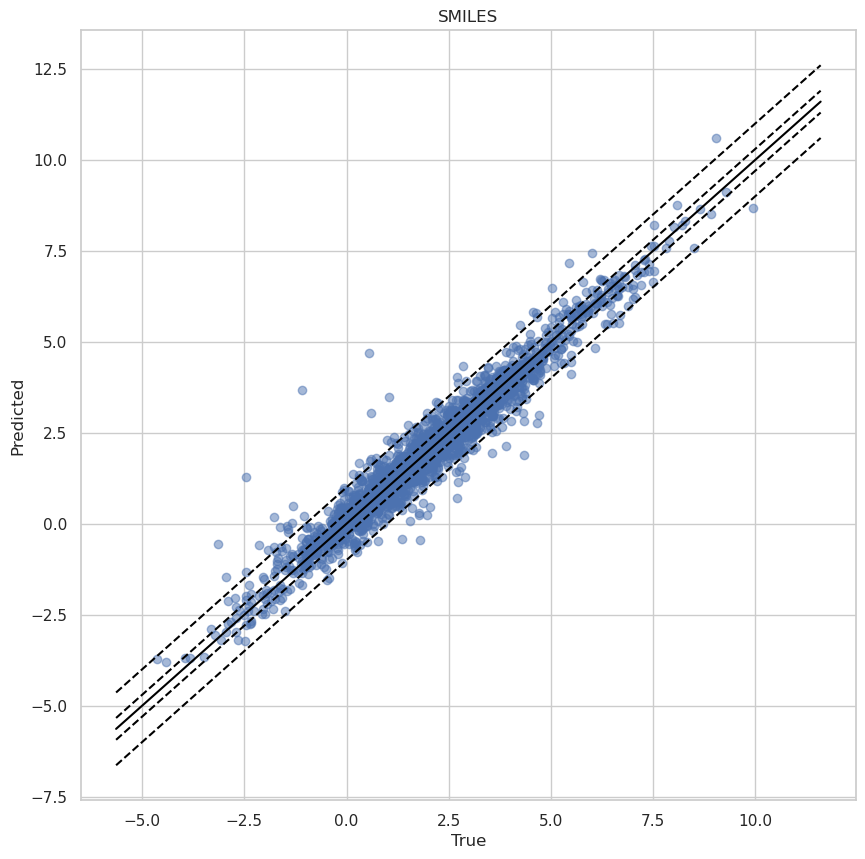

Pearson: 0.9620712001950311
R2: 0.9231389812163779
kendall_tau: 0.8600358413432098
rmse_overall: 0.9927754177747701
mae_overall: 0.6125320292392505
within_03_overall: 0.4708994708994709
within_1_overall: 0.8059964726631393


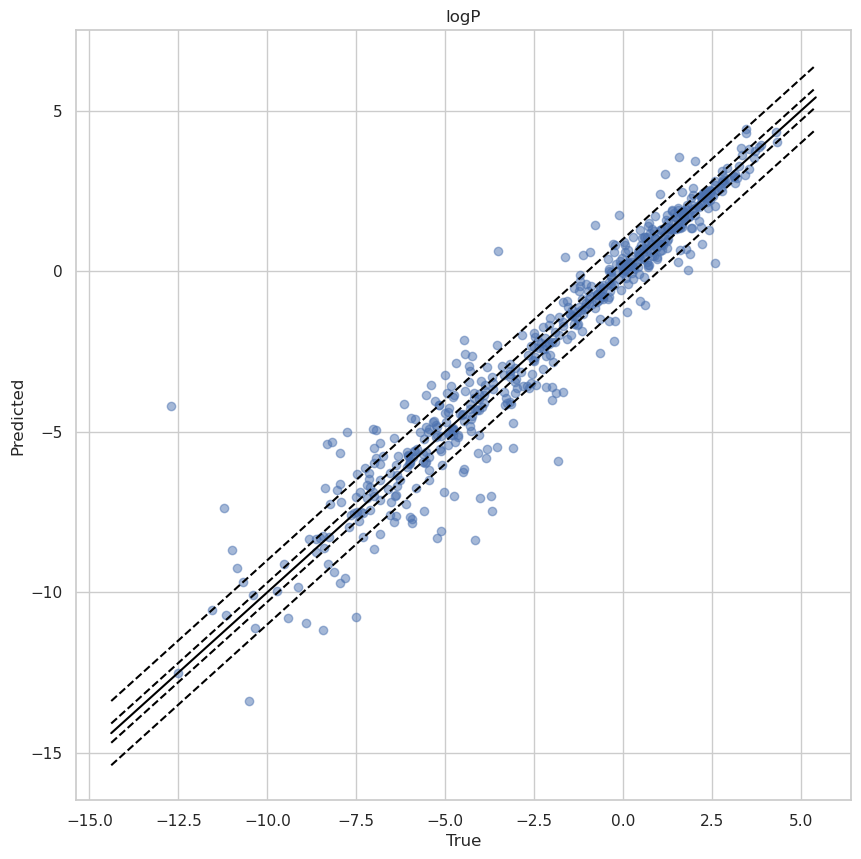

In [23]:
#not plot the outputs in same way, but for each task (colored)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
preds,ys = get_preds_per_task(test_loader, model, 2)
#get the names of the columns
column_names = df.columns[-6:]

for i in range(2):
    kendall_tau,rmse_overall,mae_overall,within_03_overall,within_1_overall = get_stats(preds[i],ys[i])
    r2 = r2_score(ys[i],preds[i])
    pearson = pearsonr(ys[i],preds[i]).statistic
    print('Pearson:',pearson)
    print('R2:',r2)
    plt.figure(figsize=(10, 10))
    plt.scatter(ys[i], preds[i], alpha=0.5)
    min_val = min(min(ys[i]),min(preds[i]))
    max_val = max(max(ys[i]),max(preds[i]))
    #add diagonal, and lines at +- 0.3 and +- 1
    plt.plot([min_val-1,max_val+1],[min_val-1,max_val+1],color='black')
    plt.plot([min_val-1,max_val+1],[min_val-1+0.3,max_val+1+0.3],color='black',linestyle='--')
    plt.plot([min_val-1,max_val+1],[min_val-1-0.3,max_val+1-0.3],color='black',linestyle='--')
    plt.plot([min_val-1,max_val+1],[min_val-1+1,max_val+1+1],color='black',linestyle='--')
    plt.plot([min_val-1,max_val+1],[min_val-1-1,max_val+1-1],color='black',linestyle='--')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title(column_names[i])
    print(f'kendall_tau: {kendall_tau}')
    print(f'rmse_overall: {rmse_overall}')
    print(f'mae_overall: {mae_overall}')
    print(f'within_03_overall: {within_03_overall}')
    print(f'within_1_overall: {within_1_overall}')
    plt.show()


In [31]:
train_data[0].y[0][0].item()

3.9100000858306885

In [32]:
train_data_logp = [d for d in train_data if d.y[0][0].item() != 0]

Epoch 1/100: Train Loss: 1.3802, Val Loss: 1.0143
Epoch 2/100: Train Loss: 0.9586, Val Loss: 0.8701
Epoch 3/100: Train Loss: 0.8365, Val Loss: 0.8103
Epoch 4/100: Train Loss: 0.7814, Val Loss: 0.7392
Epoch 5/100: Train Loss: 0.7014, Val Loss: 0.6666
Epoch 6/100: Train Loss: 0.6679, Val Loss: 0.6395
Epoch 7/100: Train Loss: 0.6445, Val Loss: 0.5986
Epoch 8/100: Train Loss: 0.6143, Val Loss: 0.5877
Epoch 9/100: Train Loss: 0.5861, Val Loss: 0.5644
Epoch 10/100: Train Loss: 0.5736, Val Loss: 0.5529
Epoch 11/100: Train Loss: 0.5568, Val Loss: 0.5405
Epoch 12/100: Train Loss: 0.5353, Val Loss: 0.5178
Epoch 13/100: Train Loss: 0.5335, Val Loss: 0.5164
Epoch 14/100: Train Loss: 0.5125, Val Loss: 0.5213
Epoch 15/100: Train Loss: 0.5127, Val Loss: 0.5560
Epoch 16/100: Train Loss: 0.5011, Val Loss: 0.5178
Epoch 17/100: Train Loss: 0.4845, Val Loss: 0.5199
Epoch 18/100: Train Loss: 0.4658, Val Loss: 0.4857
Epoch 19/100: Train Loss: 0.4623, Val Loss: 0.4809
Epoch 20/100: Train Loss: 0.4570, Val Lo

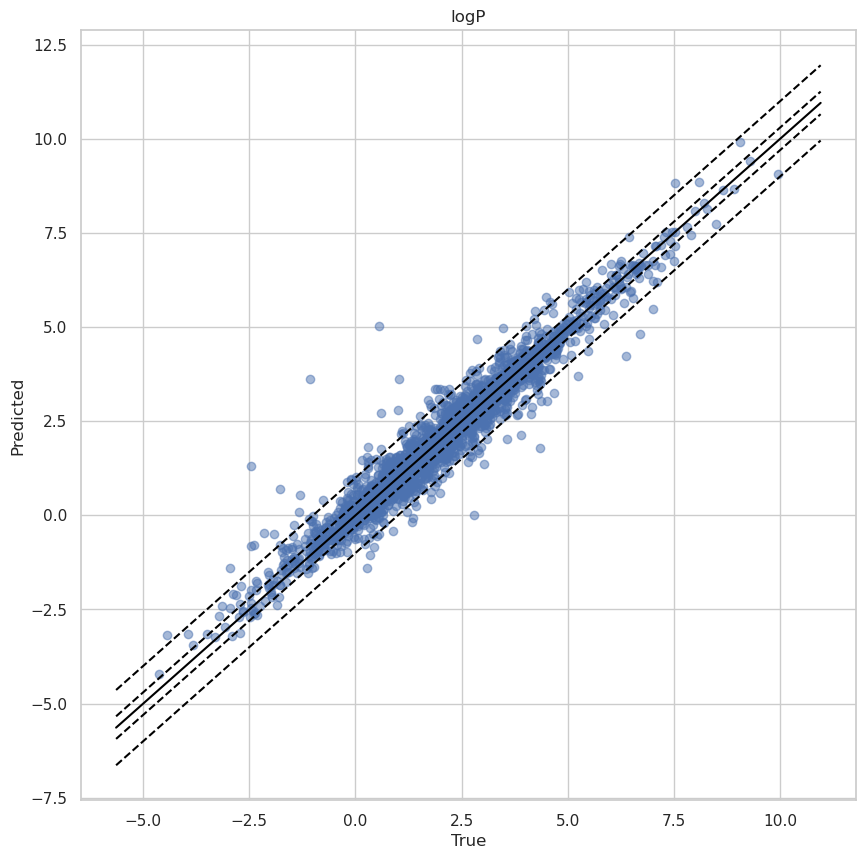

/localhome/cschiebroek/.conda/envs/mtl_dc/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100: Train Loss: 2.1066, Val Loss: 1.8065
Epoch 2/100: Train Loss: 1.4834, Val Loss: 1.1682
Epoch 3/100: Train Loss: 1.0016, Val Loss: 0.9525
Epoch 4/100: Train Loss: 0.8690, Val Loss: 0.8568
Epoch 5/100: Train Loss: 0.7411, Val Loss: 0.7924
Epoch 6/100: Train Loss: 0.7018, Val Loss: 0.7425
Epoch 7/100: Train Loss: 0.6435, Val Loss: 0.7626
Epoch 8/100: Train Loss: 0.6328, Val Loss: 0.7496
Epoch 9/100: Train Loss: 0.6011, Val Loss: 0.7387
Epoch 10/100: Train Loss: 0.6262, Val Loss: 0.7044
Epoch 11/100: Train Loss: 0.6048, Val Loss: 0.7246
Epoch 12/100: Train Loss: 0.5981, Val Loss: 0.7300
Epoch 13/100: Train Loss: 0.5803, Val Loss: 0.7055
Epoch 14/100: Train Loss: 0.5755, Val Loss: 0.7325
Epoch 15/100: Train Loss: 0.5527, Val Loss: 0.7157
Epoch 16/100: Train Loss: 0.5472, Val Loss: 0.7580
Epoch 17/100: Train Loss: 0.5349, Val Loss: 0.7212
Epoch 18/100: Train Loss: 0.5314, Val Loss: 0.7116
Epoch 19/100: Train Loss: 0.5112, Val Loss: 0.6872
Epoch 20/100: Train Loss: 0.5397, Val Lo

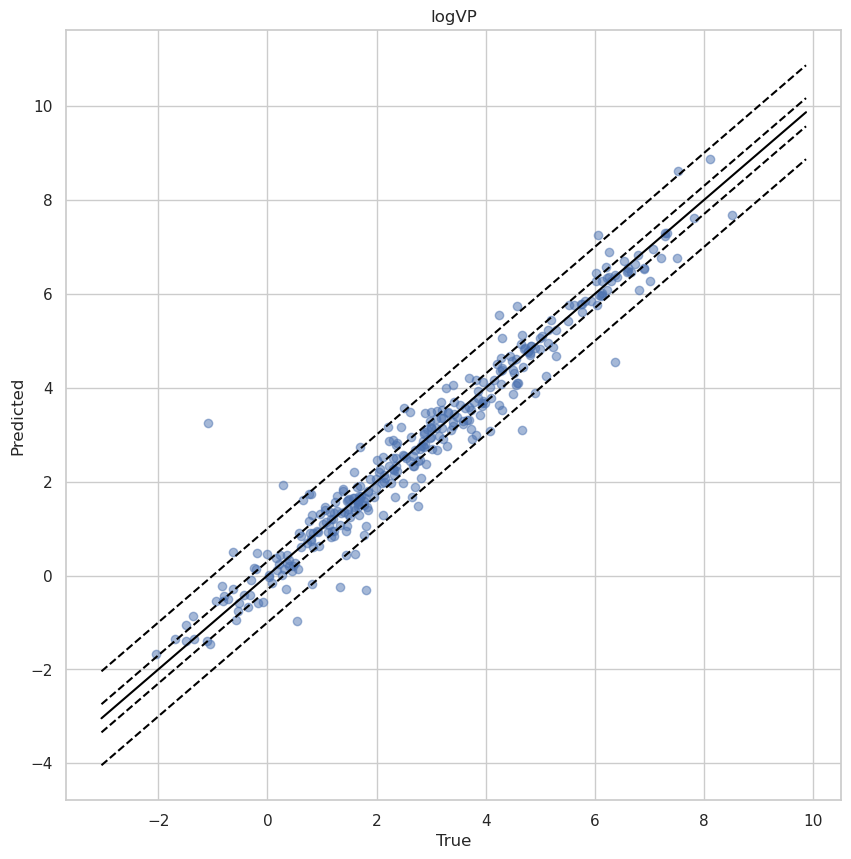

In [34]:
#also get ST:
train_data_logp = [d for d in train_data if d.y[0][0].item() != 0]
val_data_logp = [d for d in val_data if d.y[0][0].item() != 0]
test_data_logp = [d for d in test_data if d.y[0][0].item() != 0]
train_loader_logp = DataLoader(train_data_logp, batch_size=64, shuffle=True)
val_loader_logp = DataLoader(val_data_logp, batch_size=64, shuffle=False)
test_loader_logp = DataLoader(test_data_logp, batch_size=64, shuffle=False)
model_logp = AttentiveFP(in_channels=23, hidden_channels=200, out_channels=1,
                            edge_dim=11, num_layers=4, num_timesteps=2,
                            dropout=0.0).to(device)
optimizer_logp = torch.optim.Adam(model_logp.parameters(), lr=10**-3,
                        weight_decay=10**-4)
train_and_validate_multi(model_logp, train_loader_logp, val_loader_logp, optimizer_logp, num_epochs=100, outputs=1, verbose=True)
preds_logp,ys_logp = get_preds_per_task(test_loader_logp, model_logp, 1)
kendall_tau,rmse_overall,mae_overall,within_03_overall,within_1_overall = get_stats(preds_logp[0],ys_logp[0])
r2 = r2_score(ys_logp[0],preds_logp[0])
pearson = pearsonr(ys_logp[0],preds_logp[0]).statistic
print('Pearson:',pearson)
print('R2:',r2)
plt.figure(figsize=(10, 10))
plt.scatter(ys_logp[0], preds_logp[0], alpha=0.5)
min_val = min(min(ys_logp[0]),min(preds_logp[0]))
max_val = max(max(ys_logp[0]),max(preds_logp[0]))
plt.plot([min_val-1,max_val+1],[min_val-1,max_val+1],color='black')
plt.plot([min_val-1,max_val+1],[min_val-1+0.3,max_val+1+0.3],color='black',linestyle='--')
plt.plot([min_val-1,max_val+1],[min_val-1-0.3,max_val+1-0.3],color='black',linestyle='--')
plt.plot([min_val-1,max_val+1],[min_val-1+1,max_val+1+1],color='black',linestyle='--')
plt.plot([min_val-1,max_val+1],[min_val-1-1,max_val+1-1],color='black',linestyle='--')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('logP')
print(f'kendall_tau: {kendall_tau}')
print(f'rmse_overall: {rmse_overall}')
print(f'mae_overall: {mae_overall}')
print(f'within_03_overall: {within_03_overall}')
print(f'within_1_overall: {within_1_overall}')
plt.show()

#also get ST:
train_data_vp = [d for d in train_data if d.y[0][1].item() != 0]
val_data_vp = [d for d in val_data if d.y[0][1].item() != 0]
test_data_vp = [d for d in test_data if d.y[0][1].item() != 0]
train_loader_vp = DataLoader(train_data_vp, batch_size=64, shuffle=True)
val_loader_vp = DataLoader(val_data_vp, batch_size=64, shuffle=False)
test_loader_vp = DataLoader(test_data_vp, batch_size=64, shuffle=False)
model_vp = AttentiveFP(in_channels=23, hidden_channels=200, out_channels=1,
                            edge_dim=11, num_layers=4, num_timesteps=2,
                            dropout=0.0).to(device)
optimizer_vp = torch.optim.Adam(model_vp.parameters(), lr=10**-3,
                        weight_decay=10**-4)
train_and_validate_multi(model_vp, train_loader_vp, val_loader_vp, optimizer_vp, num_epochs=100, outputs=1, verbose=True)
preds_vp,ys_vp = get_preds_per_task(test_loader_vp, model_vp, 1)
kendall_tau,rmse_overall,mae_overall,within_03_overall,within_1_overall = get_stats(preds_vp[0],ys_vp[0])
r2 = r2_score(ys_vp[0],preds_vp[0])
pearson = pearsonr(ys_vp[0],preds_vp[0]).statistic
print('Pearson:',pearson)
print('R2:',r2)
plt.figure(figsize=(10, 10))
plt.scatter(ys_vp[0], preds_vp[0], alpha=0.5)
min_val = min(min(ys_vp[0]),min(preds_vp[0]))
max_val = max(max(ys_vp[0]),max(preds_vp[0]))
plt.plot([min_val-1,max_val+1],[min_val-1,max_val+1],color='black')
plt.plot([min_val-1,max_val+1],[min_val-1+0.3,max_val+1+0.3],color='black',linestyle='--')
plt.plot([min_val-1,max_val+1],[min_val-1-0.3,max_val+1-0.3],color='black',linestyle='--')
plt.plot([min_val-1,max_val+1],[min_val-1+1,max_val+1+1],color='black',linestyle='--')
plt.plot([min_val-1,max_val+1],[min_val-1-1,max_val+1-1],color='black',linestyle='--')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('logVP')
print(f'kendall_tau: {kendall_tau}')
print(f'rmse_overall: {rmse_overall}')
print(f'mae_overall: {mae_overall}')
print(f'within_03_overall: {within_03_overall}')
print(f'within_1_overall: {within_1_overall}')
plt.show()
